In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
import matplotlib.ticker as mtick

In [2]:
sys.path.append('/'.join(os.path.realpath('..').split('/')[:4]) + '/Python')
import FigureTools

In [3]:
base_dir = os.path.realpath('../..')
print(base_dir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study1_MTurk


In [4]:
gameDat = pd.read_csv(base_dir + '/Data/Cleaned/gameDat.csv',
                      index_col = 0, dtype={ 'subID':str})
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport
0,3,2003,0,G.P.,opt,nat,opt_nat,0,3,12,PD,"['Blue', 'Red']",def,def,70,1,10439,14310,maximize own score
1,3,2003,0,G.P.,opt,nat,opt_nat,1,7,8,HG,"['Blue', 'Red']",coop,coop,80,1,5259,8262,maximize own score
2,3,2003,0,G.P.,opt,nat,opt_nat,2,3,8,SH,"['Blue', 'Red']",coop,coop,80,1,2764,5519,maximize own score
3,3,2003,0,G.P.,opt,nat,opt_nat,3,7,12,SG,"['Blue', 'Red']",def,def,80,1,4497,7794,maximize own score
4,3,2003,0,G.P.,opt,nat,opt_nat,4,0,15,PD,"['Blue', 'Red']",def,def,70,1,12523,16207,maximize own score


In [5]:
gameDat['AnsNum'] = gameDat['GivenAns'].apply(lambda x: int(x == 'coop'))
gameDat['phase'] = gameDat['Trial'].apply(lambda x: 'early' if x < 8 else 'late')
gameDat['Trial_total'] = gameDat['Block']*16 + gameDat['Trial']

In [6]:
blockDat = gameDat[['subID','Type_Total','Type','Variant','ConfidenceNum','ScoreNum']
                  ].groupby(['subID','Type_Total','Type','Variant'], as_index=False).mean()
blockDat = blockDat.rename(columns={'ConfidenceNum':'Confidence','ScoreNum':'Score'})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()

150


,subID,Type_Total,Type,Variant,Confidence,Score
0,2003,opt_inv,opt,inv,50.625,0.4375
1,2003,opt_nat,opt,nat,89.375,1.0000
2,2003,pess_inv,pess,inv,50.000,0.5000
3,2003,pess_nat,pess,nat,52.500,0.5625
4,2004,opt_inv,opt,inv,53.125,0.2500


## Load cleaned file

In [7]:
all_model_fits_cleaned = pd.read_csv(base_dir +
                 '/Data/Cleaned/all_model_fits_cleaned.csv', index_col = 0)
all_model_fits_cleaned.head()

,BIC,LL,LR_down,LR_up,SSE,asymm_LR,best_model,bounded_weights,comb,comb_index,...,feature_weight_9,features,fit_to,gaze,gaze_bias,inv_temp,model_descr,model_type,sub_ID,sub_ind
0,16.391,4.281,0.158,0.158,3.278,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.906,All Motives,FeatureRL,2003,1
1,36.227,-5.637,0.333,0.333,4.468,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.235,All Motives,FeatureRL,2015,10
2,-70.566,47.760,0.194,0.194,0.842,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.262,All Motives,FeatureRL,2135,100
3,18.244,3.355,0.322,0.322,3.374,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.331,All Motives,FeatureRL,2136,101
4,53.193,-14.120,0.294,0.294,5.825,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.386,All Motives,FeatureRL,2137,102


##### Plot

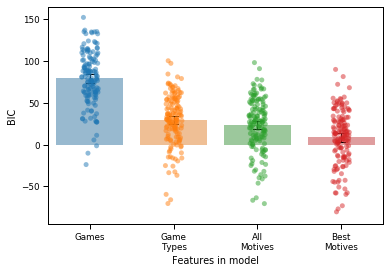

In [8]:
sns.set_context('paper')
fig,ax = plt.subplots(1,1,figsize = [6,4])
bar_order = ['Games', 'Game Types', 'All Motives', 'Best Motives']
xticklabels = ['\n'.join(a.split(' ')) for a in bar_order]

sns.barplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order, errcolor = 'k', capsize = .1, errwidth = 1)
sns.stripplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order)
# FigureTools.add_sig_markers(ax,relationships=[[2,3,0],[1,2,0]], distScale=.5, ystart = 30)
ax.set(ylabel = 'BIC', xlabel = 'Features in model',
      xticklabels = xticklabels);
# plt.savefig('/Users/jeroen/Desktop/modelcomp.pdf',transparent=True, bbox_inches = 'tight')

## Model comparison per subject - counts

In [9]:
def load_model_fits(date_string, features,
                    niter = 10, gaze = False, model_string = 'FeatureRL', fit_to = 'joint'):
    
    print(date_string, features)
    
    if model_string == "FeatureRL":
        model_fits = pd.read_csv(base_dir + 
             '/Data/Modeled/' +
             '%s_%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
                 model_string,features,date_string, fit_to, gaze, niter),
               index_col = None, dtype={'sub_ID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
    elif model_string == "BayesianIO":
        model_fits = pd.read_csv(base_dir + 
             '/Data/Modeled/' +
             '%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
                 model_string,date_string, fit_to, gaze, niter),
               index_col = 0, dtype={'subID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
        cost_type = model_fits['costType'].unique()
        if len(cost_type) > 1:
            raise ValueError('Multiple cost types detected - write code to deal with that')
        else:
            model_fits = model_fits.rename(columns = {'costVal':cost_type[0]})
    display(model_fits.head())
    print(model_fits.shape)
    return model_fits

In [10]:
model_fits = load_model_fits('2020-03-24','CoGrRiNa')

2020-03-24 CoGrRiNa


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_type,features
0,1,2003,joint,1,0001,Nash,0,0,0,1.169,...,2.571,NaN,NaN,NaN,SSE,5.333,-11.414,35.305,FeatureRL,CoGrRiNa
1,1,2003,joint,2,0010,Risk,0,0,0,0.169,...,0.415,NaN,NaN,NaN,SSE,6.374,-17.113,46.702,FeatureRL,CoGrRiNa
2,1,2003,joint,3,0011,Risk_Nash,0,0,0,0.544,...,-1.963,5.234,NaN,NaN,SSE,5.641,-13.229,43.093,FeatureRL,CoGrRiNa
3,1,2003,joint,4,0100,Greed,0,0,0,0.855,...,2.636,NaN,NaN,NaN,SSE,3.581,1.077,10.323,FeatureRL,CoGrRiNa
4,1,2003,joint,5,0101,Greed_Nash,0,0,0,0.878,...,3.418,0.481,NaN,NaN,SSE,3.458,2.187,12.261,FeatureRL,CoGrRiNa


(2250, 23)


In [11]:
bestPerSubject = pd.DataFrame()
results_model_structure_requirement = model_fits.copy()
n_subs = len(results_model_structure_requirement['sub_ID'].unique())
for sub_ID in results_model_structure_requirement['sub_ID'].unique():
    sub_dat = results_model_structure_requirement.query('sub_ID == @sub_ID').copy()
    sub_dat = sub_dat.sort_values(by=['BIC','SSE'], ascending=True)
    bestPerSubject = bestPerSubject.append(sub_dat.iloc[0])
bestPerSubject = bestPerSubject.reset_index(drop=True)
bestModelCounts = pd.DataFrame(pd.value_counts(bestPerSubject.comb)).reset_index()
bestModelCounts.columns = ['comb','count']
bestModelCounts = bestModelCounts.sort_values(by='count', ascending=False)
bestPerSubject['nDim'] = [sum([char=='1' for 
                   char in bestPerSubject.comb.values[i]]) for i in np.arange(len(bestPerSubject))]
bestPerSubject['GatherS'] = bestPerSubject.feature_names.apply(lambda x: ('Risk' in x) | ('Nash' in x))
bestPerSubject['GatherT'] = bestPerSubject.feature_names.apply(lambda x: ('Greed' in x) | ('Nash' in x))
bestPerSubject['Complexity'] = bestPerSubject['GatherS'].astype(int) + bestPerSubject['GatherT'].astype(int)
bestModelnDimCounts = pd.DataFrame(pd.value_counts(bestPerSubject.nDim)).reset_index()
bestModelnDimCounts.columns = ['nDim','count']
bestModelComplexityCounts = pd.DataFrame(pd.value_counts(bestPerSubject.Complexity)).reset_index()
bestModelComplexityCounts.columns = ['Complexity','count']
bestModelComplexityCounts = bestModelComplexityCounts.sort_values(by='count', ascending=False)
display(bestModelComplexityCounts)
bestPerSubject.head()

,Complexity,count
0,1,85
1,2,63
2,0,2


,BIC,LL,LR_down,LR_up,SSE,asymm_LR,bounded_weights,comb,comb_index,cost_type,...,gaze,gaze_bias,inv_temp,model_type,sub_ID,sub_ind,nDim,GatherS,GatherT,Complexity
0,3.576,6.530,1.867,1.867,3.055,0.0,0.0,1100,12.0,SSE,...,0.0,0.0,0.154,FeatureRL,2003,1.0,2,False,True,1
1,23.122,-5.323,0.617,0.617,4.425,0.0,0.0,0100,4.0,SSE,...,0.0,0.0,0.253,FeatureRL,2015,10.0,1,False,True,1
2,-80.387,48.511,0.424,0.424,0.823,0.0,0.0,1100,12.0,SSE,...,0.0,0.0,0.256,FeatureRL,2135,100.0,2,False,True,1
3,7.377,4.629,1.359,1.359,3.242,0.0,0.0,1001,9.0,SSE,...,0.0,0.0,0.450,FeatureRL,2136,101.0,2,True,True,2
4,19.214,-1.289,0.932,0.932,3.901,0.0,0.0,1100,12.0,SSE,...,0.0,0.0,0.496,FeatureRL,2137,102.0,2,False,True,1


In [12]:
label_list = ['Coop.','Greed','Risk','Nash']
bestModelCounts['comb_labels'] = bestModelCounts['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
bestModelCounts['pct'] = bestModelCounts['count']/n_subs*100
bestModelComplexityCounts['pct'] = bestModelComplexityCounts['count']/n_subs*100
bestModelnDimCounts['pct'] = bestModelnDimCounts['count']/n_subs*100

In [13]:
n_models_in_plot = 8
bestModelCounts_trunc = bestModelCounts.iloc[:n_models_in_plot,:]
bestModelCounts_trunc

,comb,count,comb_labels,pct
0,1100,46,"Coop.,\nGreed",30.666667
1,0100,37,Greed,24.666667
2,1101,13,"Coop.,\nGreed,\nNash",8.666667
3,0101,12,"Greed,\nNash",8.000000
4,0110,9,"Greed,\nRisk",6.000000
5,0111,7,"Greed,\nRisk,\nNash",4.666667
6,1110,7,"Coop.,\nGreed,\nRisk",4.666667
7,1001,5,"Coop.,\nNash",3.333333


In [14]:
bmc_other = pd.DataFrame(bestModelCounts.iloc[n_models_in_plot:,:].sum()
                        ).T[['count','comb_labels','pct']]
bmc_other.loc[0,'comb_labels'] = 'other'
bestModelCounts_aggTrunc = bestModelCounts.iloc[:n_models_in_plot,:].append(
    bmc_other, sort = False)
bestModelCounts_aggTrunc

,comb,count,comb_labels,pct
0,1100,46,"Coop.,\nGreed",30.6667
1,0100,37,Greed,24.6667
2,1101,13,"Coop.,\nGreed,\nNash",8.66667
3,0101,12,"Greed,\nNash",8
4,0110,9,"Greed,\nRisk",6
5,0111,7,"Greed,\nRisk,\nNash",4.66667
6,1110,7,"Coop.,\nGreed,\nRisk",4.66667
7,1001,5,"Coop.,\nNash",3.33333
0,NaN,14,other,9.33333


In [15]:
bestModelnDimCounts

,nDim,count,pct
0,2,75,50.0
1,1,45,30.0
2,3,30,20.0


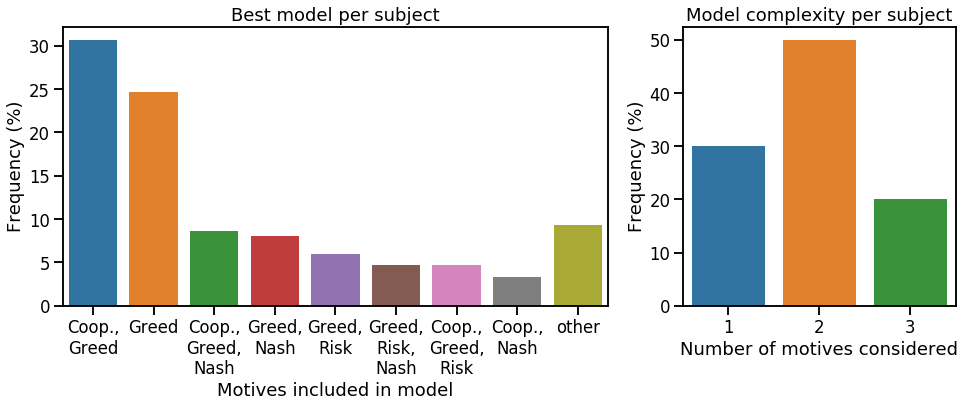

In [16]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6],
                       gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = bestModelnDimCounts, x='nDim', y='pct', order = [1,2,3], ax = ax[1])
ax[1].set(xlabel = 'Number of motives considered', ylabel = 'Frequency (%)',
       title = 'Model complexity per subject');
plt.tight_layout()

## Which dimensions are used by people from the Coop, Opt, and Pess groups (self-report)?

In [20]:
DIYquiz = pd.read_csv(base_dir+'/Data/Cleaned/DIYquiz.csv',
                      dtype = {'subID':str}, index_col=0)
DIYquiz = DIYquiz.replace(to_replace = {'none':'other','env':'other'})

In [21]:
DIYquiz = DIYquiz.merge(bestPerSubject[['sub_ID','comb','nDim']], 
                        left_on='subID', right_on = 'sub_ID')
DIYquiz.head()

,sub,subID,selfType,typicalType,sub_ID,comb,nDim
0,3,2003,opt,opt,2003,1100,2
1,4,2004,trust,other,2004,0100,1
2,5,2005,trust,trust,2005,0101,2
3,6,2006,trust,trust,2006,1100,2
4,8,2008,other,other,2008,0100,1


In [22]:
ownType_totals = DIYquiz['selfType'].value_counts()
ownType_totals

trust    66
other    40
opt      24
pess     13
Nash      7
Name: selfType, dtype: int64

In [23]:
combs = DIYquiz['comb'].unique()
combs.sort()
combs

array(['0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000',
       '1001', '1011', '1100', '1101', '1110'], dtype=object)

In [24]:
combCountsAll = pd.DataFrame(columns=combs, index=DIYquiz['selfType'].unique())
combCountsAll[:] = 0
combCountsAll
for st in DIYquiz['selfType'].unique():
    combCounts = DIYquiz.loc[DIYquiz['selfType']==st,'comb'].value_counts(dropna=False)
    for comb in combCounts.index.values:
        combCountsAll.loc[st, comb] = combCounts[comb]
combCountsAll

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1011,1100,1101,1110
opt,0,1,0,6,2,1,0,0,0,1,10,2,1
trust,1,0,0,17,5,4,0,0,2,1,23,9,4
other,3,0,3,13,2,1,0,2,1,1,11,2,1
pess,0,0,0,0,2,3,4,0,2,0,1,0,1
Nash,0,1,0,1,1,0,3,0,0,0,1,0,0


In [25]:
combs_considered = combCountsAll.columns
featuresByGroup_nrs = pd.DataFrame(columns=[0,1,2,3], index = combCountsAll.index)
featuresByGroup_nrs[:] = 0
for feature in [0,1,2,3]:
    columnsToCheck = []
    for comb in combs_considered:
        if comb[feature]=='1':
            columnsToCheck.append(comb)
    for st in combCountsAll.index:
        featuresByGroup_nrs.loc[st, feature] = np.sum(combCountsAll.loc[st, columnsToCheck])
featuresByGroup_nrs.columns = ['Coop','Greed','Risk','Nash']
featuresByGroup_nrs

,Coop,Greed,Risk,Nash
opt,14,22,4,5
trust,39,62,9,18
other,18,30,6,12
pess,4,11,8,8
Nash,1,6,4,4


##### Is 'risk' motive more common in 'pess' people?

In [26]:
motive_type_pairs = {'Coop':'trust','Greed':'opt','Risk':'pess','Nash':'Nash'}

In [27]:
for motive,ownType in motive_type_pairs.items():
    print(motive,ownType)
    distr_in_group = [featuresByGroup_nrs.loc[ownType][motive],
                    ownType_totals[ownType] - featuresByGroup_nrs.loc[ownType][motive]]
    distr_out_group = [featuresByGroup_nrs.loc[featuresByGroup_nrs.index != ownType][motive].sum(), 
         (ownType_totals.loc[ownType_totals.index != ownType].sum() - 
          featuresByGroup_nrs.loc[featuresByGroup_nrs.index != ownType][motive].sum())]
    print(scipy.stats.binom_test(distr_in_group, p = distr_out_group[0]/np.sum(distr_out_group),
                                 alternative='greater'))

Coop trust
0.009928026277975826
Greed opt
0.3535104371871916
Risk pess
0.0003634242745457703
Nash Nash
0.12694448235341507


In [28]:
motive = 'Coop'
ownType = motive_type_pairs[motive]
distr_in_group = [featuresByGroup_nrs.loc[ownType][motive],
                ownType_totals[ownType] - featuresByGroup_nrs.loc[ownType][motive]]
distr_out_group = [featuresByGroup_nrs.loc[featuresByGroup_nrs.index != ownType][motive].sum(), 
     (ownType_totals.loc[ownType_totals.index != ownType].sum() - 
      featuresByGroup_nrs.loc[featuresByGroup_nrs.index != ownType][motive].sum())]
print(distr_in_group)
print(distr_out_group)
print(scipy.stats.binom_test(distr_in_group, p = distr_out_group[0]/np.sum(distr_out_group),
                             alternative='greater'))

[39, 27]
[37, 47]
0.009928026277975826


##### Visualize

In [29]:
featuresByGroup_pct = featuresByGroup_nrs.copy()
for st in featuresByGroup_pct.index:
    featuresByGroup_pct.loc[st,:] = featuresByGroup_nrs.loc[st,:] / ownType_totals.loc[st]
featuresByGroup_pct.loc['total',:] = featuresByGroup_nrs.sum(axis=0)/149
featuresByGroup_pct

,Coop,Greed,Risk,Nash
opt,0.583333,0.916667,0.166667,0.208333
trust,0.590909,0.939394,0.136364,0.272727
other,0.450000,0.750000,0.150000,0.300000
pess,0.307692,0.846154,0.615385,0.615385
Nash,0.142857,0.857143,0.571429,0.571429
total,0.510067,0.879195,0.208054,0.315436


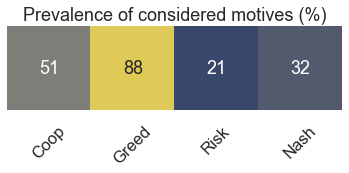

In [31]:
sns.set(context = 'talk', style = 'white', font = 'arial')
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=[6,5])
sns.heatmap(featuresByGroup_pct.iloc[[-1],:]*100,
            annot=True,fmt='.0f', square = True, cbar = False,
            vmin = 0, vmax = 100, cmap = 'cividis', yticklabels = [None],
           )
ax.set(ylim = [0,1], title = 'Prevalence of considered motives (%)');
plt.xticks(rotation=45); plt.yticks(rotation=0);

In [32]:
# Colormap
from matplotlib.colors import LinearSegmentedColormap, to_rgb
list_hex = ['#B2182B', '#D6604D', '#F4A582', '#FDDBC7', '#FFFFFF', '#D1E5F0', '#92C5DE', '#4393C3', '#2166AC']
list_rgb = [to_rgb(c) for c in list_hex[::-1]]
list_rgb
CoopDef_cmap = LinearSegmentedColormap.from_list('CoopDef',list_rgb)
CoopDef_cmap

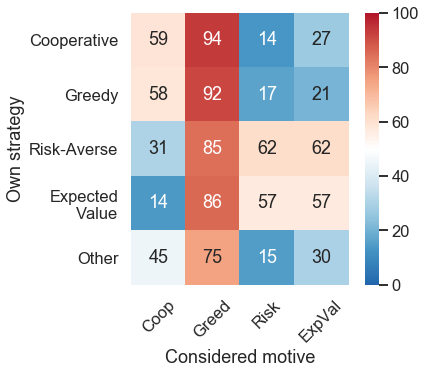

In [33]:
sns.set(context = 'talk', style = 'white', font = 'arial')
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=[6,5])
y_order = ['trust','opt','pess','Nash','other']
y_indices = [featuresByGroup_pct.index.tolist().index(a) for a in y_order]
ylabels_long = ['Cooperative','Greedy','Risk-Averse','Expected\nValue','Other']
xlabels_long = ['Coop','Greed','Risk','ExpVal']
sns.heatmap(featuresByGroup_pct.iloc[[yo for yo in y_indices],:]*100,
            annot=True,fmt='.0f', square = True, cbar = True,
            vmin = 0, vmax = 100, cmap = CoopDef_cmap,
           yticklabels = ylabels_long, xticklabels = xlabels_long,
           )
ax.set(ylim = [0,5], ylabel = 'Own strategy', xlabel = 'Considered motive',
      title = None);
plt.xticks(rotation=45); plt.yticks(rotation=0);
ax.invert_yaxis();